In [1]:
%load_ext autoreload
%autoreload 2

# Transform

In [2]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose([
    A.HorizontalFlip(.5),
    A.ShiftScaleRotate(shift_limit=.05, scale_limit=.1, rotate_limit=15, p=.7),
    A.CoarseDropout(num_holes_range=(4, 8), hole_width_range=(0.05, 0.2), hole_height_range=(0.05, 0.2), p=.5),
    A.OneOf([
        A.GaussianBlur(blur_limit=(3, 7), p=0.5),
        A.MotionBlur(blur_limit=(3, 7), p=0.5),
    ], p=0.5),
    A.GaussNoise(var_limit=(1.0, 1.0), p=0.5),
    A.ColorJitter(brightness=.3, contrast=.3, saturation=.3, hue=.02, p=.8),
    A.RandomBrightnessContrast(p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]),
    ToTensorV2()
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

/Users/ruslanf/Library/Python/3.9/lib/python/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/var/folders/4b/m8ykh5795flg_b6s_rlsz5h40000gn/T/ipykernel_78209/2964887981.py:12: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(1.0, 1.0), p=0.5),


# Dataset Loader

In [3]:
from birds_classification import BirdsDataset
from torch.utils.data import DataLoader, random_split
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

batch_size = 64

train_dataset = BirdsDataset('./tests/00_test_img_input/train/images', './tests/00_test_img_input/train/gt.csv', transform=transform, device=device)
val_dataset = BirdsDataset('./tests/00_test_img_input/train/images', './tests/00_test_img_input/train/gt.csv', device=device)
test_dataset = BirdsDataset('./tests/00_test_img_input/test/images', device=device)

train_size = int(.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_subset, _ = random_split(train_dataset, (train_size, val_size))
_, val_subset = random_split(val_dataset, (train_size, val_size))

train_loader = DataLoader(train_subset, batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=True)

/Users/ruslanf/Library/Python/3.9/lib/python/site-packages/albumentations/core/composition.py:331: UserWarning: Got processor for keypoints, but no transform to process it.
  self._set_keys()
/Users/ruslanf/Library/Python/3.9/lib/python/site-packages/albumentations/core/composition.py:331: UserWarning: Got processor for keypoints, but no transform to process it.
  self._set_keys()
/Users/ruslanf/Library/Python/3.9/lib/python/site-packages/albumentations/core/composition.py:331: UserWarning: Got processor for keypoints, but no transform to process it.
  self._set_keys()


# Metrics Visualizer

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Train Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b-', label='Train Accuracy')
    plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Loading Mobilenet v2

In [5]:
import torch

model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
for param in model.parameters():
    param.requires_grad = False
print(model)

Using cache found in /Users/ruslanf/.cache/torch/hub/pytorch_vision_v0.10.0


MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

# Fitting Custom Layer

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Train:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1 - train accuracy: 0.0260 - train loss: 3.9509 - val accuracy: 0.0760 - val loss: 3.731690
Validation loss improved (inf --> 3.731690). Saving model...


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2 - train accuracy: 0.0625 - train loss: 3.7284 - val accuracy: 0.1840 - val loss: 3.231996
Validation loss improved (3.731690 --> 3.231996). Saving model...


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3 - train accuracy: 0.1515 - train loss: 3.4223 - val accuracy: 0.4020 - val loss: 2.534370
Validation loss improved (3.231996 --> 2.534370). Saving model...


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4 - train accuracy: 0.2260 - train loss: 3.0915 - val accuracy: 0.4620 - val loss: 2.161800
Validation loss improved (2.534370 --> 2.161800). Saving model...


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5 - train accuracy: 0.2630 - train loss: 2.9565 - val accuracy: 0.4200 - val loss: 2.188653
Validation loss did not improve. Counter: 1/5


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6 - train accuracy: 0.2660 - train loss: 3.0711 - val accuracy: 0.4340 - val loss: 2.370569
Validation loss did not improve. Counter: 2/5


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7 - train accuracy: 0.2985 - train loss: 2.9706 - val accuracy: 0.5460 - val loss: 1.771161
Validation loss improved (2.161800 --> 1.771161). Saving model...


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8 - train accuracy: 0.3065 - train loss: 2.8630 - val accuracy: 0.5780 - val loss: 1.693221
Validation loss improved (1.771161 --> 1.693221). Saving model...


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9 - train accuracy: 0.3300 - train loss: 2.8042 - val accuracy: 0.6320 - val loss: 1.553109
Validation loss improved (1.693221 --> 1.553109). Saving model...


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10 - train accuracy: 0.3345 - train loss: 2.7526 - val accuracy: 0.6560 - val loss: 1.504694
Validation loss improved (1.553109 --> 1.504694). Saving model...


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11 - train accuracy: 0.3785 - train loss: 2.5932 - val accuracy: 0.6540 - val loss: 1.434891
Validation loss improved (1.504694 --> 1.434891). Saving model...


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12 - train accuracy: 0.3640 - train loss: 2.6123 - val accuracy: 0.6640 - val loss: 1.435228
Validation loss did not improve. Counter: 1/5


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13 - train accuracy: 0.3980 - train loss: 2.4629 - val accuracy: 0.7100 - val loss: 1.326864
Validation loss improved (1.434891 --> 1.326864). Saving model...


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14 - train accuracy: 0.4130 - train loss: 2.4072 - val accuracy: 0.7200 - val loss: 1.281752
Validation loss improved (1.326864 --> 1.281752). Saving model...


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15 - train accuracy: 0.4100 - train loss: 2.3721 - val accuracy: 0.7640 - val loss: 1.214248
Validation loss improved (1.281752 --> 1.214248). Saving model...


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16 - train accuracy: 0.4380 - train loss: 2.2847 - val accuracy: 0.7700 - val loss: 1.193005
Validation loss improved (1.214248 --> 1.193005). Saving model...


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 17 - train accuracy: 0.4410 - train loss: 2.2577 - val accuracy: 0.7660 - val loss: 1.179113
Validation loss improved (1.193005 --> 1.179113). Saving model...


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18 - train accuracy: 0.4345 - train loss: 2.3054 - val accuracy: 0.7700 - val loss: 1.153468
Validation loss improved (1.179113 --> 1.153468). Saving model...


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19 - train accuracy: 0.4710 - train loss: 2.1806 - val accuracy: 0.7720 - val loss: 1.147733
Validation loss improved (1.153468 --> 1.147733). Saving model...


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20 - train accuracy: 0.4675 - train loss: 2.2026 - val accuracy: 0.7880 - val loss: 1.138591
Validation loss improved (1.147733 --> 1.138591). Saving model...
Finished Training. Loaded best model.


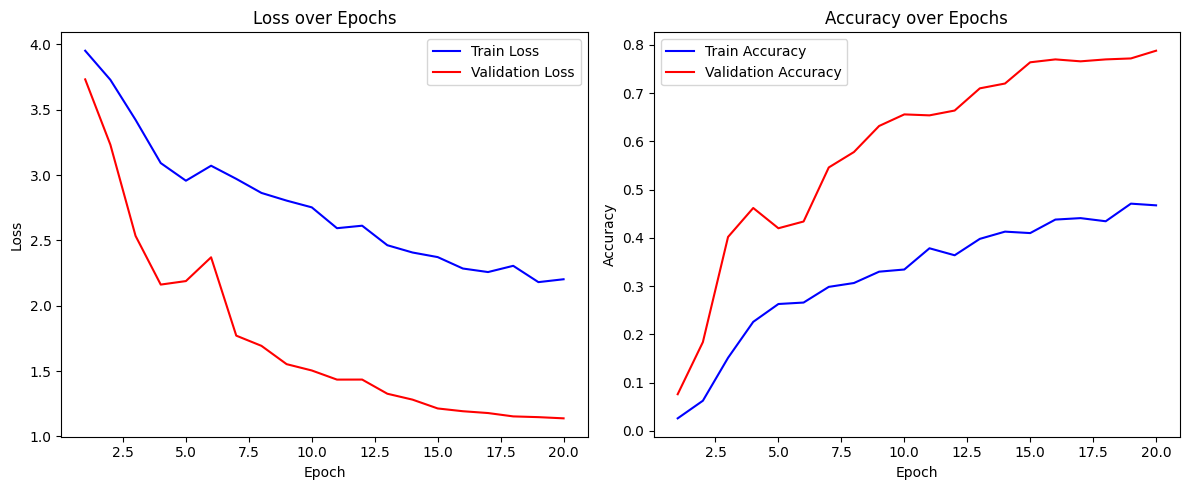

In [7]:
from torch import nn, optim
import numpy as np
from tqdm.notebook import tqdm 
import os


num_classes = 50

model.classifier = nn.Sequential(
    nn.Dropout(.2),
    nn.Linear(1280, num_classes),
)
model.to(device)


epochs = 20

params_to_update = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.AdamW(params_to_update, lr=1e-3)
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=5e-3, 
    steps_per_epoch=len(train_loader),
    epochs=epochs,
    pct_start=0.3,
)

best_val_loss = np.inf
epochs_no_improve = 0
patience = 7
model_path_finetune = 'birds_classification_finetune.pth'

train_accuracies = []
train_losses = []
val_accuracies = []
val_losses = []

for epoch in tqdm(range(epochs), position=0, desc='Epoch'):
    model.train()
    train_loss = train_correct = train_seen = 0
    val_loss = val_correct = val_seen = 0

    with tqdm(train_loader, position=1, leave=False, desc='Train') as pbar:
        for i, data in enumerate(pbar):
            inputs, targets = data[0].to(device), data[1].to(device).long()

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            # nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
            optimizer.step()
            scheduler.step()

            train_loss += loss.item() * inputs.size(0)
            train_correct += torch.sum(outputs.argmax(dim=-1)==targets).item()
            train_seen   += inputs.size(0)
            pbar.set_postfix(
                loss=f"{train_loss/train_seen:.4f}",
                accuracy=f"{train_correct/train_seen:.4f}"
            )

    model.eval()
    with torch.no_grad():
        for data in val_loader:
            inputs, targets = data[0].to(device), data[1].to(device).long()
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item() * inputs.size(0)
            val_correct += torch.sum(outputs.argmax(dim=-1)==targets).item()
            val_seen += inputs.size(0)
    
    train_loss /= train_seen
    train_accuracy = train_correct / train_seen
    val_loss /= val_seen
    val_accuracy = val_correct / val_seen
    
    tqdm.write(f'Epoch {epoch+1} - train accuracy: {train_accuracy:.4f} - train loss: {train_loss:.4f} - val accuracy: {val_accuracy:.4f} - val loss: {val_loss:.4f}')
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    if val_loss < best_val_loss:
        tqdm.write(f'Validation loss improved ({best_val_loss:.4f} --> {val_loss:.4f}). Saving model...')
        torch.save(model.state_dict(), model_path_finetune)
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        tqdm.write(f'Validation loss did not improve. Counter: {epochs_no_improve}/{patience}')

    if epochs_no_improve >= patience:
        tqdm.write('Early stopping triggered.')
        break


if os.path.exists(model_path_finetune):
    model.load_state_dict(torch.load(model_path_finetune))
    print('Finished Training. Loaded best model.')
else:
    print('No improvement during training. Using final model.')

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

# Fine-Tuning the Rest of the Model

  0%|          | 0/15 [00:00<?, ?it/s]

Train:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1 - train accuracy: 0.4620 - train loss: 1.9825 - val accuracy: 0.7780 - val loss: 0.747467
Validation loss improved (inf --> 0.747467). Saving model...


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2 - train accuracy: 0.4850 - train loss: 1.8666 - val accuracy: 0.8020 - val loss: 0.675109
Validation loss improved (0.747467 --> 0.675109). Saving model...


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3 - train accuracy: 0.4790 - train loss: 1.7977 - val accuracy: 0.8000 - val loss: 0.635139
Validation loss improved (0.675109 --> 0.635139). Saving model...


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4 - train accuracy: 0.5050 - train loss: 1.7107 - val accuracy: 0.8220 - val loss: 0.590703
Validation loss improved (0.635139 --> 0.590703). Saving model...


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5 - train accuracy: 0.5200 - train loss: 1.6592 - val accuracy: 0.8420 - val loss: 0.537365
Validation loss improved (0.590703 --> 0.537365). Saving model...


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6 - train accuracy: 0.5330 - train loss: 1.5875 - val accuracy: 0.8640 - val loss: 0.520536
Validation loss improved (0.537365 --> 0.520536). Saving model...


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7 - train accuracy: 0.5580 - train loss: 1.5163 - val accuracy: 0.8700 - val loss: 0.504232
Validation loss improved (0.520536 --> 0.504232). Saving model...


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8 - train accuracy: 0.5660 - train loss: 1.4866 - val accuracy: 0.8540 - val loss: 0.484389
Validation loss improved (0.504232 --> 0.484389). Saving model...


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9 - train accuracy: 0.5705 - train loss: 1.4151 - val accuracy: 0.8660 - val loss: 0.466167
Validation loss improved (0.484389 --> 0.466167). Saving model...


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10 - train accuracy: 0.5915 - train loss: 1.3856 - val accuracy: 0.8700 - val loss: 0.444593
Validation loss improved (0.466167 --> 0.444593). Saving model...


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11 - train accuracy: 0.6040 - train loss: 1.3474 - val accuracy: 0.8740 - val loss: 0.444347
Validation loss improved (0.444593 --> 0.444347). Saving model...


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12 - train accuracy: 0.6240 - train loss: 1.2630 - val accuracy: 0.8740 - val loss: 0.437482
Validation loss improved (0.444347 --> 0.437482). Saving model...


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13 - train accuracy: 0.6120 - train loss: 1.2879 - val accuracy: 0.8720 - val loss: 0.428496
Validation loss improved (0.437482 --> 0.428496). Saving model...


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14 - train accuracy: 0.6345 - train loss: 1.2582 - val accuracy: 0.8760 - val loss: 0.431580
Validation loss did not improve. Counter: 1/5


Train:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15 - train accuracy: 0.6355 - train loss: 1.2714 - val accuracy: 0.8760 - val loss: 0.431184
Validation loss did not improve. Counter: 2/5
Finished Training. Loaded best model.


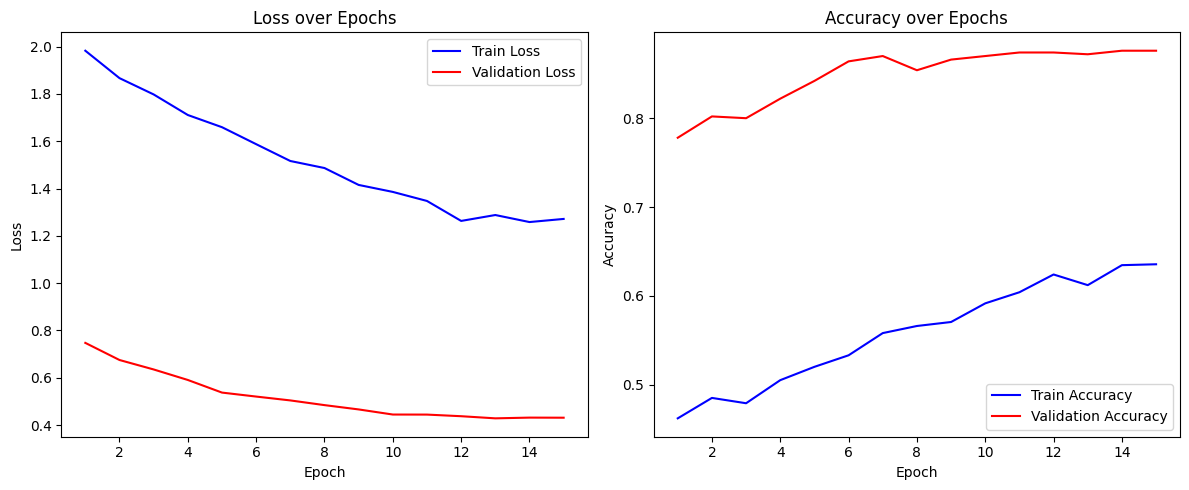

In [8]:
from tqdm.notebook import tqdm 
import os

for layer in list(model.children())[0][-4:]:
    for param in layer.parameters():
        param.requires_grad = True

epochs = 15

params_to_update = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.AdamW(params_to_update, lr=1e-6)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-4, 
    steps_per_epoch=len(train_loader),
    epochs=epochs,
    pct_start=0.3,
)

best_val_loss = np.inf
epochs_no_improve = 0
patience = 5
model_path = 'birds_classification.pth'

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in tqdm(range(epochs)):
    model.train()
    train_loss = train_correct = train_seen = 0
    val_loss = val_correct = val_seen = 0

    with tqdm(train_loader, position=1, leave=False, desc='Train') as pbar:
        for i, data in enumerate(pbar):
            inputs, targets = data[0].to(device), data[1].to(device).long()

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            # nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
            optimizer.step()
            scheduler.step()

            train_loss += loss.item() * inputs.size(0)
            train_correct += torch.sum(outputs.argmax(dim=-1)==targets).item()
            train_seen   += inputs.size(0)
            pbar.set_postfix(
                loss=f"{train_loss/train_seen:.4f}",
                acc=f"{train_correct/train_seen:.4f}"
            )

    model.eval()
    with torch.no_grad():
        for data in val_loader:
            inputs, targets = data[0].to(device), data[1].to(device).long()
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item() * inputs.size(0)
            val_correct += torch.sum(outputs.argmax(dim=-1)==targets).item()
            val_seen += inputs.size(0)
    
    train_loss /= train_seen
    train_accuracy = train_correct / train_seen
    val_loss /= val_seen
    val_accuracy = val_correct / val_seen
    
    tqdm.write(f'Epoch {epoch+1} - train accuracy: {train_accuracy:.4f} - train loss: {train_loss:.4f} - val accuracy: {val_accuracy:.4f} - val loss: {val_loss:.4f}')
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    if val_loss < best_val_loss:
        tqdm.write(f'Validation loss improved ({best_val_loss:.4f} --> {val_loss:.4f}). Saving model...')
        torch.save(model.state_dict(), model_path)
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        tqdm.write(f'Validation loss did not improve. Counter: {epochs_no_improve}/{patience}')

    if epochs_no_improve >= patience:
        tqdm.write('Early stopping triggered.')
        break

if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    print('Finished Training. Loaded best model.')
else:
    print('No improvement during training. Using final model.')

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

In [10]:
test_loader = DataLoader(val_dataset, batch_size, shuffle=True)
test_loss = test_correct = test_seen = 0

model.eval()
with torch.no_grad():
    for data in test_loader:
        inputs, targets = data[0].to(device), data[1].to(device).long()
        outputs = model(inputs)
        test_loss += criterion(outputs, targets).item() * inputs.size(0)
        test_correct += torch.sum(outputs.argmax(dim=-1)==targets).item()
        test_seen += inputs.size(0)
    
test_loss /= test_seen
test_accuracy = test_correct / test_seen

print(f'Test accuracy: {test_accuracy:.4f} - test loss: {test_loss:.6f}')

Test accuracy: 0.8604 - test loss: 0.447891
